## Trained vs Untrained using Graph Neural Network and PPO Model
- Model:L2DPPOModel

## Environment setup

In [27]:
import torch
from rl4co.utils import RL4COTrainer
from rl4co.envs import DJSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

generator_params = {
"num_jobs" : 8 ,
"num_machines": 8 ,
"min_processing_time": 20 ,
"max_processing_time": 99 ,
"mtbf": 30,
"mttr": 10
}
env = DJSSPEnv(generator_params=generator_params,
_torchrl_mode=True,
stepwise_reward=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
torch.cuda.is_available()

True

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 32
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

### WandB

In [30]:
import wandb
from lightning.pytorch.loggers import WandbLogger

run = wandb.init(
    project = "rl4co",
    notes = "GNN-PPO-Training"
)


logger = WandbLogger(project="rl4co", name="GNN-PPO-Training")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\wandb\sdk\wandb_init.py:202: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  settings = self._wl.settings.copy()
wandb: Currently logged in as: fazli-kiraz (fazli-kiraz-ruhr-university-bochum). Use `wandb login --relogin` to force relogin


## Policy - Model

In [31]:

policy_kwargs = {
    "embed_dim": 256 ,
    "num_encoder_layers": 3,
    "scaling_factor": 1000,
    "ppo_epochs": 2,
    "het_emb": False,
    "normalization": "instance",
    "test_decode_type": "greedy"
}

model = L2DPPOModel(env=env, policy_kwargs=policy_kwargs ,batch_size=batch_size,val_batch_size=512,test_batch_size=64,mini_batch_size=512)

C:\Users\soner\Desktop\rl4co\rl4co\models\zoo\l2d\policy.py:48: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  log.warn(f"Unused kwargs: {constructive_policy_kw}")
Unused kwargs: {'ppo_epochs': 2}
Found 1 unused kwargs: {'ppo_epochs': 2}
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Scheduling of the `untrained Model`

In [32]:
td_init = env.reset(batch_size=[1])
# we must send td to device otherwise it throws an error
td_init = td_init.to(device)

In [33]:
# same for the policy
policy = model.policy.to(device=device)

### Greedy

In [34]:
out_untrained_greedy = policy(td_init.clone(), env, phase="test", decode_type="greedy")

print("Untrained greedy output with the makespan ", out_untrained_greedy["reward"][0])

# for multiple batches use this:
# print(f"Greedy - Rewards: {[f'{-r.item():.2f}' for r in out_untrained_greedy['reward']]}")


Untrained greedy output with the makespan  tensor(-1108.2883, device='cuda:0')


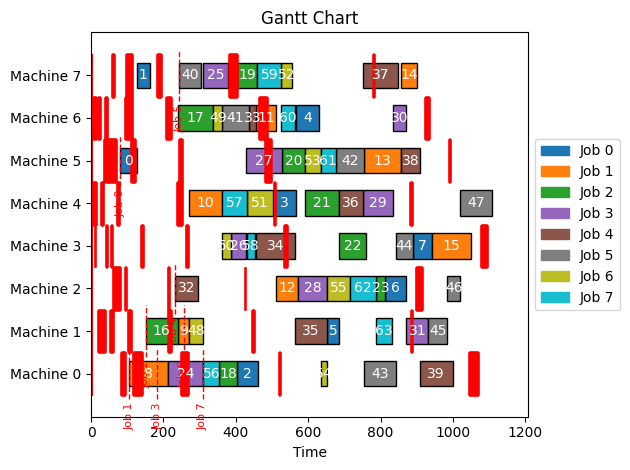

In [35]:
# render the output of the untrained greedy
env.render(out_untrained_greedy["td"] , 0)

### MultistartSampling

In [36]:
out_untrained_multistart = policy.generate(td_init.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
print(f"Untrained Multistart - Makespan: {[f'{-r.item():.2f}' for r in out_untrained_multistart['reward']]}")

Untrained Multistart - Makespan: ['1002.61']


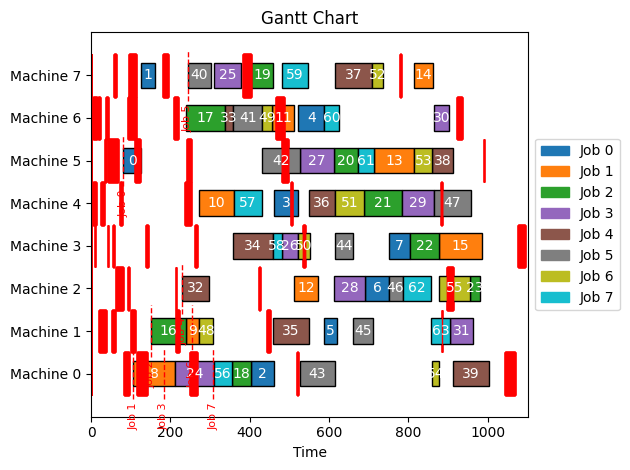

In [37]:
env.render(out_untrained_multistart["td"] , 0)

# Training the model

### Checkpoint - Callback Setup

In [38]:
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints", # save to checkpoints/
                                        filename="epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward
# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]



### Training

In [39]:
#CHECKPOINT_PATH = "last.ckpt"
CHECKPOINT_PATH = "checkpoints/last.ckpt"
try:
    model = L2DPPOModel.load_from_checkpoint(CHECKPOINT_PATH)
except FileNotFoundError:

    # max_epochs = 10
    trainer = RL4COTrainer(
    max_epochs=10,
    accelerator=accelerator,
    devices=1,
    logger=logger,
    callbacks=callbacks
    )

    trainer.fit(model)
finally:
    model = model.to(device)


Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Overriding gradient_clip_val to None for 'automatic_optimization=False' models
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:45: Attribute 'policy' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['policy'])`.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

Detected KeyboardInterrupt,

NameError: name 'exit' is not defined

# Scheduling performance of the trained model

In [ ]:
td_init = td_init.to(device)
# same for the policy
policy = model.policy.to(device=device)

### Greedy

In [ ]:
out_trained_greedy = policy(td_init.clone(), env, phase="test", decode_type="greedy")

print("Trained greedy output with the makespan ", out_trained_greedy["reward"][0])

In [ ]:
env.render(out_trained_greedy["td"] , 0)

### Multistart

In [ ]:
out_trained_multistart = policy.generate(td_init.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
print(f"Trained Multistart - Rewards: {[f'{-r.item():.2f}' for r in out_trained_multistart['reward']]}")


In [ ]:
env.render(out_trained_multistart["td"] , 0)

# Test on Taillard Benchmark

In [ ]:
! git clone https://github.com/tamy0612/JSPLIB.git


In [ ]:
import json
import os


def prepare_taillard_data(nj, nm):
    # Target folder for Taillard instances
    fp = f"taillard/{nj}x{nm}"

    if not os.path.exists(fp):
        os.makedirs(fp)

    # Load the JSON file
    with open('JSPLIB/instances.json', 'r') as file:
        data = json.load(file)

    # Filter Taillard instances with matching jobs and machines
    instances = [x for x in data if "ta" in x["name"] and x["jobs"] == nj and x["machines"] == nm]
    print(f"Found {len(instances)} instances for {nj} jobs and {nm} machines")

    if not instances:
        raise FileNotFoundError(f"No matching Taillard instances found for {nj}x{nm}")

    # Copy files and validate
    for instance in instances:
        source_path = os.path.join("JSPLIB", instance['path'])
        target_path = os.path.join(fp, f"{instance['name']}.txt")

        # Check if the source file exists
        if os.path.exists(source_path):
            print(f"Copying {source_path} to {target_path}")
            os.system(f"cp {source_path} {target_path}")
        else:
            print(f"Warning: Source file {source_path} does not exist")

    # Verify if files were copied
    files_in_target = os.listdir(fp)
    assert len(files_in_target) > 0, f"No files copied to {fp}. Check source paths."
    print(f"Successfully prepared {len(files_in_target)} files in {fp}")

In [ ]:
import gc

device = "cuda" if torch.cuda.is_available() else "cpu"

# path to taillard instances
FILE_PATH = "taillard/{nj}x{nm}"

results = {}
instance_types = [(15, 15), (20, 15), (20, 20), (30, 15), (30, 20)]

for instance_type in instance_types:
    print("------------")
    nj, nm = instance_type
    prepare_taillard_data(nj, nm)
    dataset = env.dataset(batch_size=[10], phase="test", filename=FILE_PATH.format(nj=nj, nm=nm))
    dl = DataLoader(dataset, batch_size=5, collate_fn=dataset.collate_fn)
    rewards = []

    for batch in dl:
        td_init = env.reset(batch).to(device)
        # use policy.generate to avoid grad calculations which can lead to oom
        out = model.policy.generate(td_init, env=env, phase="test", decode_type="multistart_sampling", num_starts=100, select_best=True)
        rewards.append(out["reward"])

    reward = torch.cat(rewards, dim=0).mean().item()
    results[instance_type] = reward

    print("Done evaluating instance type %s with reward %s" % (instance_type, reward))

    # avoid ooms due to cache not being cleared
    model.rb.empty()
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
wandb.finish()